## Goal: simulate a 1D boundary layer of a magma ocean planet

# Current goals and issues

1. The spatial pattern for the uniform forcing $F_0$ case looks fine. √
2. The time evolution for the uniform forcing $F_0$ case looks fine. √
3. The spartial pattern for the diffential forcing $F(x)$ case is problematic. Something is wrong in the advection or the boundary conditions. 

In [2]:
# Import python libraries
import numpy as np
import matplotlib.pyplot as plt 

In [3]:
# Create parameter class

class parameters:
    
    # Spatial grid
    rp   = 6314e3           # radius of the planet in m
    ndeg = 5                # number of X-grid
    ddeg = 1
    dx   = rp*np.pi/ndeg    # resolution of X-grid 
    x    = np.arange(0,ndeg+ddeg,ddeg)*dx        # X-grid in m
    xlen = len(x)           # length of X-grid
    
    # Temporal grid
    dt   = 180 # seconds
    tmin = 0
    tmax = dt*1e6
    t    = np.arange(tmin,tmax+dt,dt)
    tlen = len(t)
    
    # CFL criterion must be met
    if not dt/dx < 0.4:
        print('CFL criterion is not met.')
        quit()
        
    # Thermodynamics of Atmosphere
    M  = 18e-3    # molar weight of the atmosphere, unit in kg/mol
    R  = 8.314/M  # gas constant of the amtosphere, unit in J/kg/K          
    cp = 1864     # specific heat of the atmosphere, unit in J/kg/K
    cv = cp-R     # specific heat, unit in J/kg/K
    L  = 2260e3   # latent heat of condensation, unit in J/kg
    
    # Thermodynamics of Ocean
    cpo  = 1 # speficic of the liquid in ocean, unit in J/kg/K， water is 4184
    rhoo = 1000 # density of the ocean, unit in kg/m^3
    ho   = 75 # depth of the ocean, unit in m
    Co  = cpo*rhoo*ho # heat capacity of the ocean per unit surface area, J/m^2/K
    
    # Clausius-Clapeyron relation
    pref = 3533 # reference pressure in Pa
    Tref = 300  # reference temperature in K
    
    # Other parameters
    F = 800      # solar heating in W/m2 
    g   = 10     # gravity in m/s^2
    tau = dt*100 # friction damping timescale in s
    sigma = 5.67e-8

In [4]:
def get_esat(x):
    # Saturation Vapor Pressure
    # Input x could be T or Ts in K
    esat = np.zeros([par.xlen],dtype='float')
    esat = par.pref * np.exp(-(par.L/par.R)*(1/x - 1/par.Tref))
    return esat

In [21]:
def get_p0():
    p_free  = 0
    p0 = np.ones([par.xlen],dtype='float')
    p0 = p0 * p_free
    return p0

In [22]:
def __init__(self):
    # generate variables and combine them with parameters
    self.Ts , self.ps   , self.rhodel, self.E       ,\
    self.u  , self.alpha,\
    self.rho, self.delta, self.Cm    , self.Cu      ,\
    self.Fnet, self.OLR\
    = (np.zeros([parameters.tlen,parameters.xlen],dtype='float') for i in range(12))

In [23]:
def get_Cm():
    # Diagnostic at current time step, i
    Cm = np.zeros([par.xlen],dtype='float')
    Cm = par.E[i,:]
    return Cm

In [24]:
def get_Cu():
    # Diagnostic at current time step, i
    Cu = np.zeros([par.xlen],dtype='float')
    Cu = -par.rho[i,:]*par.delta[i,:]*par.u[i,:]/par.tau    
    return Cu  

In [26]:
def get_Fnet(option = 1):
    # generate parameter (Fnet) with specific distributions
     
    # distribution of solar forcing
    if option == 1:     # uniform distribution
        F_solar = par.F * np.ones([par.xlen],dtype='float')
        Fnet = F_solar - par.sigma * par.Ts[i+1,:] ** 4
        
    elif option == 2:   # sine distribution (needs to be revised if periodic boundary condition)
        F_solar = par.F * (np.sin(np.pi/2 * np.arange(0, par.ndeg + par.ddeg, par.ddeg) / par.ndeg) + 1)
        Fnet = F_solar - par.sigma * par.Ts[i+1,:] ** 4
    else:               # no forcing
        Fnet = np.zeros([par.xlen],dtype='float')

    return Fnet

In [27]:
def get_Ts(): 
    # Prognostic
    Ts = np.zeros([par.xlen],dtype='float')

    Ts = par.Ts[i,:] + par.dt / par.Co*\
            (
             par.Fnet[i,:] - par.L * par.E[i,:]
            )   
    return Ts

In [28]:
def get_ps(): 
    # Diagnostic
    ps = np.zeros([par.xlen], dtype='float')
    
    ps = get_esat(par.Ts[i+1, :])
    return ps

In [ ]:
def get_rho():
    # Diagnostic
    rho = np.zeros([par.xlen],dtype='float') # (t+1)
    rho = par.ps[i+1,:]/(par.R * par.Ts[i+1,:])

    if (any(n < 0 for n in rho) == True):
        print('rho is negative! Quit.')
        quit()

    return rho

In [2]:
def get_delta():
    # Diagnostic
    delta = np.zeros([par.xlen],dtype='float') # (t+1)
    delta = (par.ps[i+1,:]-par.p0[:])/(par.g*par.rho[i+1,:])
    if (any(n < 0 for n in delta) == True):
        print('delta is negative! Quit.')
        quit()
    return delta

In [ ]:
def get_rhodel():
    # Diagnostic
    rhodel = np.zeros([par.xlen],dtype='float') # (t+1)
    rhodel = par.rho[i+1,:]*par.delta[i+1,:]
    return rhodel

In [30]:
def get_u(): 
    # Prognostic
    rhodelu = np.zeros([par.xlen],dtype='float') # (t+1)
    u = np.zeros([par.xlen],dtype='float')       # (t+1)
    
    # interior
    for j in range(1, par.xlen-1):
        if par.u[i,j]>=0:
            rhodelu[j] = par.rho[i,j]*par.delta[i,j]*par.u[i,j] +                                \
                         par.dt*(par.Cu[i,j] -                                                   
                                    (                                                                
                                    par.delta[i,j]  *(par.rho[i,j]  *par.u[i,j]**2   + par.ps[i,j])-   
                                    par.delta[i,j-1]*(par.rho[i,j-1]*par.u[i,j-1]**2 + par.ps[i,j-1]) 
                                    )/                                                               
                                    (par.x[j]-par.x[j-1])                                            
                                    )
        elif par.u[i,j]<0:
            rhodelu[j] = par.rho[i,j]*par.delta[i,j]*par.u[i,j] +                                \
                         par.dt*(par.Cu[i,j] -                                                   
                                (                                                                
                                par.delta[i,j+1]*(par.rho[i,j+1]*par.u[i,j+1]**2   + par.ps[i,j+1])-   
                                par.delta[i,j]  *(par.rho[i,j]  *par.u[i,j]**2     + par.ps[i,j]) 
                                )/                                                               
                                (par.x[j+1]-par.x[j])                                            
                                )
    # Periodic boundary conditions
    j = 0
    if par.u[i,j]>=0:
        rhodelu[j] = par.rho[i,j]*par.delta[i,j]*par.u[i,j] +  \
                        par.dt*(par.Cu[i,j] -                                                   
                                    (                                                                
                                    par.delta[i,j]  *(par.rho[i,j]  *par.u[i,j]**2   + par.ps[i,j])-   
                                    par.delta[i,-2]*(par.rho[i,-2]*par.u[i,-2]**2 + par.ps[i,-2]) 
                                    )/                                                               
                                    (par.dx)                                            
                                    )
    elif par.u[i,j]<0:
        rhodelu[j] = par.rho[i,j]*par.delta[i,j]*par.u[i,j] +                                \
                         par.dt*(par.Cu[i,j] -                                                   
                                (                                                                
                                par.delta[i,j+1]*(par.rho[i,j+1]*par.u[i,j+1]**2   + par.ps[i,j+1])-   
                                par.delta[i,j]  *(par.rho[i,j]  *par.u[i,j]**2     + par.ps[i,j]) 
                                )/                                                               
                                (par.x[j+1]-par.x[j])                                            
                                )
    j = par.xlen-1
    rhodelu[j] = rhodelu[0]
    
    u = rhodelu[:]/par.rhodel[i+1,:]
    return u

In [ ]:
def get_alpha():
    alpha = np.zeros([par.xlen],dtype='float') # (t+1)
    alpha = (par.ps[i+1,:]*par.L**2)/(par.R*par.Ts[i+1,:]**2*par.Co*par.g)
    return alpha

In [36]:
def get_E(): # **
    # Diagnostic
    E = np.zeros([par.xlen],dtype='float') # (t+1)
    
    # interior
    for j in range(1, par.xlen-1):
        if par.u[i,j]>=0:
            E[j] =  (par.alpha[i+1,j]*par.Fnet[i+1,j]/par.L +
                       (par.rho[i+1,j]  *par.delta[i+1,j]  *par.u[i+1,j]              
                        -par.rho[i+1,j-1]*par.delta[i+1,j-1]*par.u[i+1,j-1]        
                        )/(par.dx)
                    )/(par.alpha[i+1,j]+1)
        elif par.u[i,j]<0:
            E[j] = (par.alpha[i+1,j]*par.Fnet[i+1,j]/par.L +
                        (par.rho[i+1,j+1]  *par.delta[i+1,j+1]  *par.u[i+1,j+1]              
                         -par.rho[i+1,j]*par.delta[i+1,j]*par.u[i+1,j]        
                        )/(par.dx)
                    )/(par.alpha[i+1,j]+1)
    # Periodic boundary conditions
    # left boundary
    j = 0
    if par.u[i,j]>=0:
        E[j] = (par.alpha[i+1,j]*par.Fnet[i+1,j]/par.L +
                       (par.rho[i+1,j]  *par.delta[i+1,j]  *par.u[i+1,j]              
                        -par.rho[i+1,-2]*par.delta[i+1,-2]*par.u[i+1,-2]        
                        )/(par.dx)
                )/(par.alpha[i+1,j]+1)
    elif par.u[i,j]<0:
        E[j] = (par.alpha[i+1,j]*par.Fnet[i+1,j]/par.L +
                        (par.rho[i+1,j+1]  *par.delta[i+1,j+1]  *par.u[i+1,j+1]              
                         -par.rho[i+1,j]*par.delta[i+1,j]*par.u[i+1,j]        
                        )/(par.dx)
                    )/(par.alpha[i+1,j]+1)
    # right boundary
    j = par.xlen-1
    E[j] =  E[0]
    
    return E

In [41]:
def get_initial_conditions(Ts0 = 300, u0 = 0, option = 1):
    # Scenario: intially saturated atmosphere with uniform Ts,T,p,delta,etc.
    i = 0
    
    par.Ts[i,:]       = np.ones([par.xlen],dtype='float') * Ts0 # uniform initial temp
    par.ps[i,:]       = get_esat(par.Ts[i,:])                   # uniform initial pressure
    par.rhodel[i,:]   = (par.ps[i,:]-par.p0[:])/par.g           # uniform atmospheric mass
    par.u[i,:]        = np.ones([par.xlen],dtype='float') * u0  # initial wind
    par.rho[i,:]      = par.ps[i,:]/(par.R*par.Ts[i,:])
    par.delta[i,:]    = par.rhodel[i,:]/par.rho[i,:]
    par.alpha[i,:]    = (par.ps[i,:]*par.L**2)/(par.R*par.Ts[i,:]**2*par.Co*par.g)          
    
    # distribution of initial solar forcing
    par.Fnet[i,:] = np.zeros([par.xlen],dtype='float')
    if option == 1:     # uniform distribution
        F_solar = par.F * np.ones([par.xlen],dtype='float')
        par.Fnet[i,:] = F_solar - par.sigma * par.Ts[i,:] **4      
    elif option == 2:   # cosine distribution (needs to be revised if periodic boundary condition)
        F_solar = par.F * np.cos(np.pi * np.arange(0, par.ndeg + par.ddeg, par.ddeg) / par.ndeg)
        par.Fnet[i,:] = F_solar - par.sigma * par.Ts[i,:] **4
    
    par.E[i,:]    = np.zeros([par.xlen],dtype='float')      # zero surface mass-flux   
    # interior
    for j in range(1, par.xlen-1):
        if par.u[i,j]>=0:
            E[i,j] =  (par.alpha[i,j]*par.Fnet[i,j]/par.L +
                       (par.rho[i,j]  *par.delta[i,j]  *par.u[i,j]              
                        -par.rho[i,j-1]*par.delta[i,j-1]*par.u[i,j-1]        
                        )/(par.dx)
                    )/(par.alpha[i,j]+1)
        elif par.u[i,j]<0:
            E[i,j] = (par.alpha[i,j]*par.Fnet[i,j]/par.L +
                        (par.rho[i,j+1]  *par.delta[i,j+1]  *par.u[i,j+1]              
                         -par.rho[i,j]*par.delta[i,j]*par.u[i,j]        
                        )/(par.dx)
                    )/(par.alpha[i,j]+1)
    # Periodic boundary conditions
    # left boundary
    j = 0
    if par.u[i,j]>=0:
        E[i,j] = (par.alpha[i,j]*par.Fnet[i,j]/par.L +
                       (par.rho[i,j]  *par.delta[i,j]  *par.u[i,j]              
                        -par.rho[i,-2]*par.delta[i,-2]*par.u[i,-2]        
                        )/(par.dx)
                )/(par.alpha[i,j]+1)
    elif par.u[i,j]<0:
        E[i,j] = (par.alpha[i,j]*par.Fnet[i,j]/par.L +
                        (par.rho[i,j+1]  *par.delta[i,j+1]  *par.u[i,j+1]              
                         -par.rho[i,j]*par.delta[i,j]*par.u[i,j]        
                        )/(par.dx)
                    )/(par.alpha[i,j]+1)
    # right boundary
    j = par.xlen-1
    E[i,j] =  E[i,0]


In [42]:
# Time Integration
par = parameters()
__init__(par)
par.p0 = get_p0()
get_initial_conditions()

for i in range(par.tlen-1): 
    # Get variables at current time step
    par.Cm[i,:]         = get_Cm()
    par.Cu[i,:]         = get_Cu()

    # Get variables at the next time step
    par.Ts[i+1,:]       = get_Ts()
    par.Fnet[i+1,:]     = get_Fnet(option=1)
    par.ps[i+1,:]       = get_ps()
    par.rho[i+1,:]      = get_rho()
    par.delta[i+1,:]    = get_delta() 
    par.rhodel[i+1,:]   = get_rhodel()
    par.u[i+1,:]        = get_u() 
    par.alpha[i+1,:]    = get_alpha()         
    par.E[i+1,:]        = get_E() 
    
    f_report = 10        # report every time when this fraction is completed
    idx = (par.tlen-1)/f_report
    if (i%idx == 0 ):
        progress = round(i/par.tlen*100)
        print("{} % completed".format(progress))
        
print('Success!')

0 % completed
10 % completed
20 % completed
30 % completed
40 % completed
50 % completed
60 % completed
70 % completed
80 % completed
90 % completed
Success!


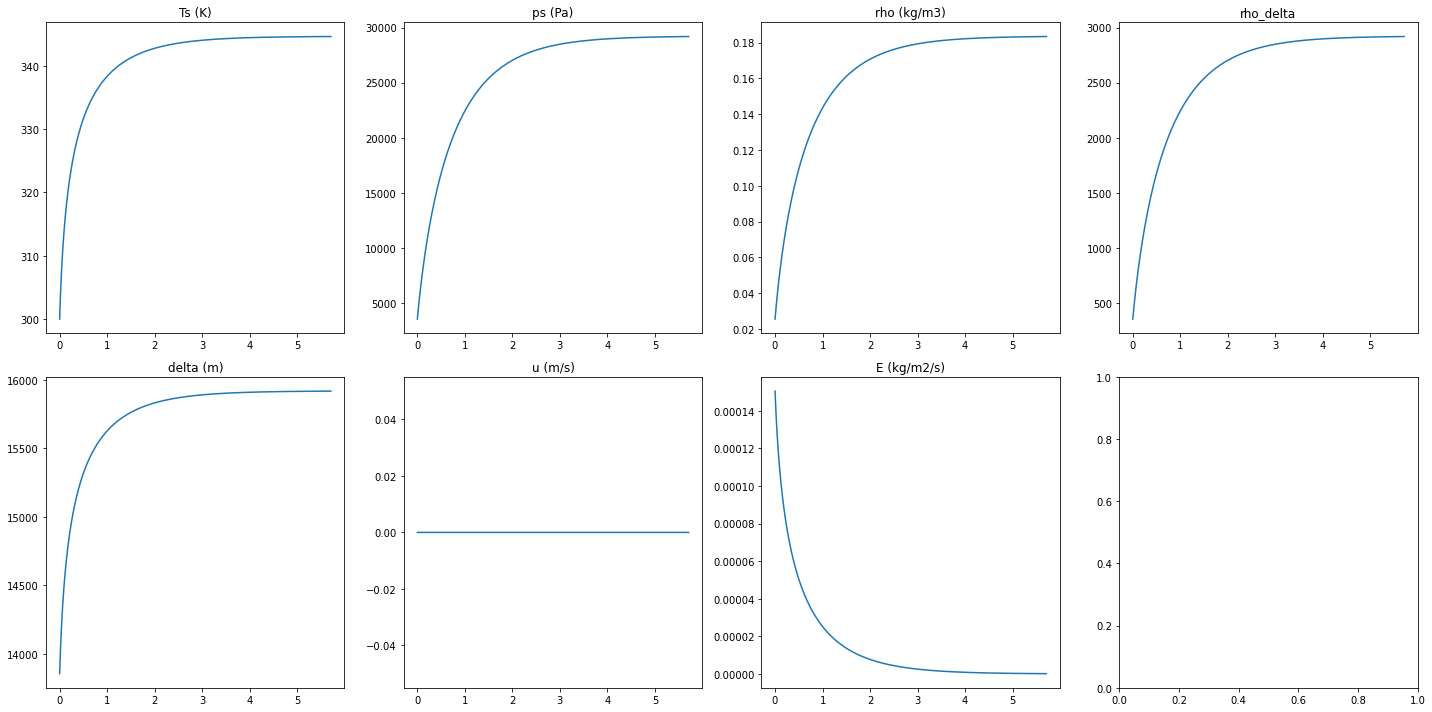

In [43]:
# Plot time-evolution  
fig, ax = plt.subplots(2,4,figsize=(20,10)) 

L_year = 3600*24*365

# Plot at end of the simulation
ax[0,0].plot(par.t/L_year,par.Ts[:,0]) 
ax[0,1].plot(par.t/L_year,par.ps[:,0]) 
ax[0,2].plot(par.t/L_year,par.rho[:,0]) 
ax[0,3].plot(par.t/L_year,par.rhodel[:,0]) 
ax[1,0].plot(par.t/L_year,par.delta[:,0])
ax[1,1].plot(par.t/L_year,par.u[:,0]) 
ax[1,2].plot(par.t/L_year,par.E[:,0])

ax[0,0].set_title('Ts (K)')
ax[0,1].set_title('ps (Pa)')
ax[0,2].set_title('rho (kg/m3)')
ax[0,3].set_title('rho_delta')
ax[1,0].set_title('delta (m)')
ax[1,1].set_title('u (m/s)')
ax[1,2].set_title('E (kg/m2/s)')

# for i in (0,1):
#     for j in (0,4):
#         ax[i,j].set_xlim([0.3, 0.6])

plt.tight_layout()
plt.show()

In [ ]:
# print(par.Ts[:,0])
# print(par.ps[:,0])
# print(par.rhodel[:,0])
# print(par.e[:,0])
# print(par.T[:,0])
# print(par.p[:,0])
# print(par.rho[:,0])
# print(par.delta[:,0])
print(par.E[:,0])
print(par.P[:,0])

1. Warm start (compared to EQ, T > Ts, p > ps, check "e")
2. Switch from non - periodic to periodic domain
3. Merge the codes with the latest version!
4. 

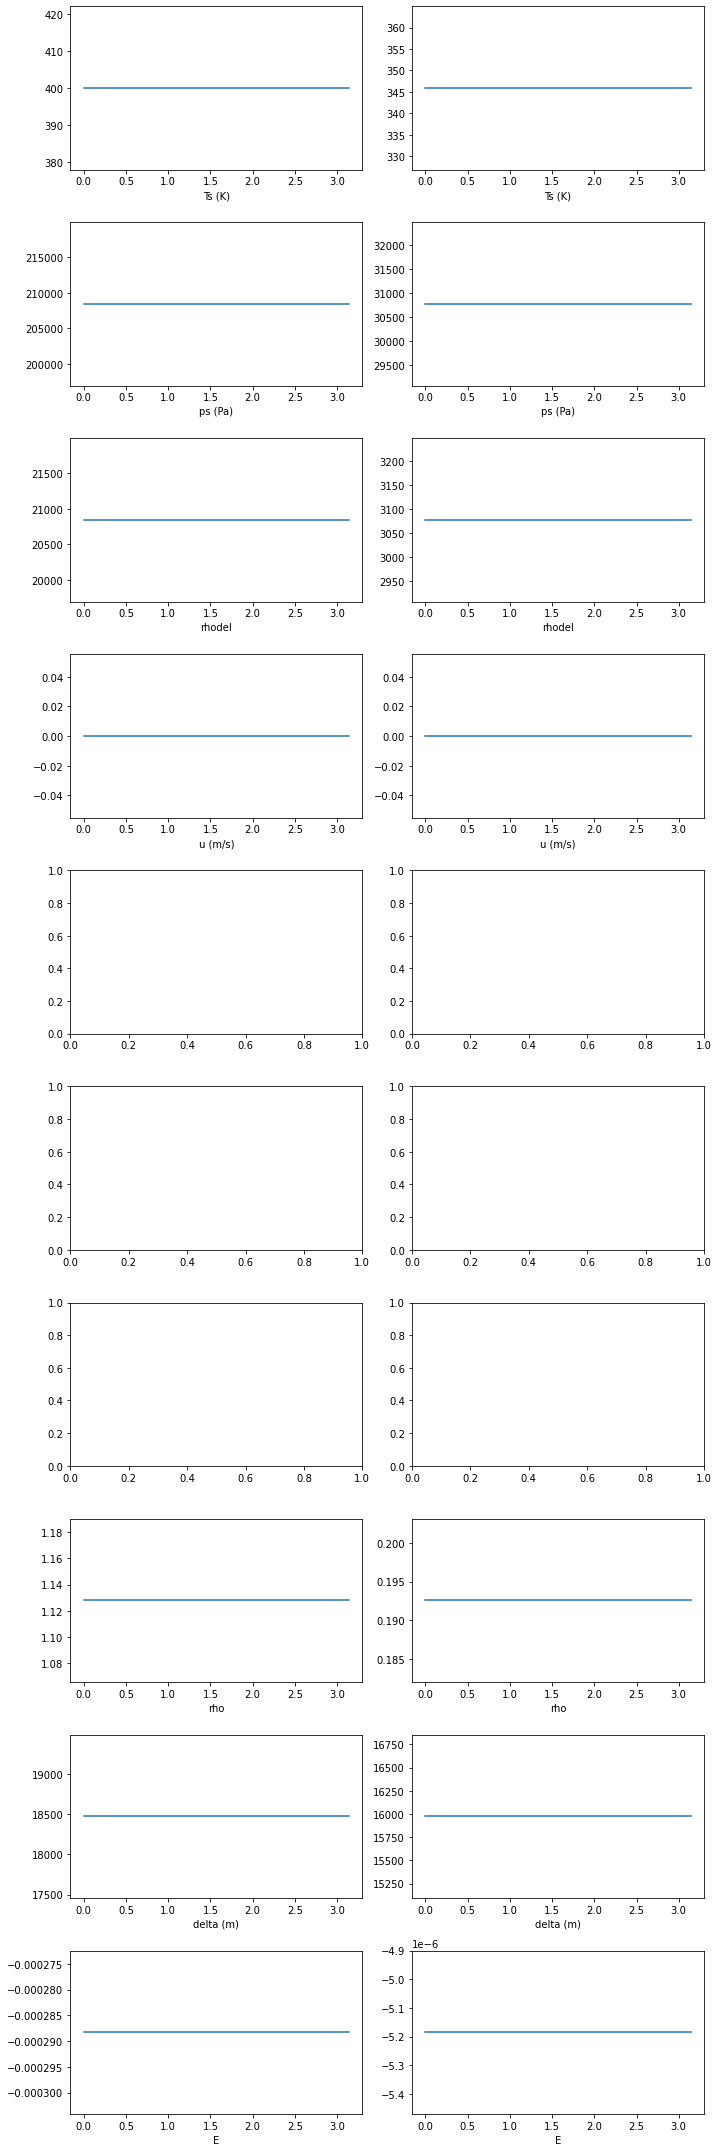

In [172]:
# Plot distribution  
fig, ax = plt.subplots(10,2,figsize=(10,30)) 

# Plot at end of the simulation
ax[0,0].plot(par.x/par.rp,par.Ts[0,:]) 
ax[1,0].plot(par.x/par.rp,par.ps[0,:]) 
ax[2,0].plot(par.x/par.rp,par.rhodel[0,:]) 
ax[3,0].plot(par.x/par.rp,par.u[0,:]) 
# ax[4,0].plot(par.x/par.rp,par.e[0,:]) 
# ax[5,0].plot(par.x/par.rp,par.T[0,:]) 
# ax[6,0].plot(par.x/par.rp,par.p[0,:]) 
ax[7,0].plot(par.x/par.rp,par.rho[0,:]) 
ax[8,0].plot(par.x/par.rp,par.delta[0,:])
ax[9,0].plot(par.x/par.rp,par.E[0,:])

i = -1
ax[0,1].plot(par.x/par.rp,par.Ts[i,:]) 
ax[1,1].plot(par.x/par.rp,par.ps[i,:]) 
ax[2,1].plot(par.x/par.rp,par.rhodel[i,:]) 
ax[3,1].plot(par.x/par.rp,par.u[i,:]) 
# ax[4,1].plot(par.x/par.rp,par.e[i,:]) 
# ax[5,1].plot(par.x/par.rp,par.T[i,:]) 
# ax[6,1].plot(par.x/par.rp,par.p[i,:]) 
ax[7,1].plot(par.x/par.rp,par.rho[i,:]) 
ax[8,1].plot(par.x/par.rp,par.delta[i,:])
ax[9,1].plot(par.x/par.rp,par.E[i,:])

for c in range(0,2):    
    ax[0,c].set_xlabel('Ts (K)')
    ax[1,c].set_xlabel('ps (Pa)')
    ax[2,c].set_xlabel('rhodel')
    ax[3,c].set_xlabel('u (m/s)')
#     ax[4,c].set_xlabel('e')
#     ax[5,c].set_xlabel('T (K)')
#     ax[6,c].set_xlabel('p (Pa)')
    ax[7,c].set_xlabel('rho')
    ax[8,c].set_xlabel('delta (m)')
    ax[9,c].set_xlabel('E')
plt.tight_layout()
plt.show()